In [5]:
import numpy as np
import torch.nn as nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.optim as optim

import PIL              #Pillow Imaging Library
from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as models

In [125]:
dtype = torch.FloatTensor
imsize=200

loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),
    transforms.ToTensor()])

preprocess = loader

def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(preprocess(image))
    image = image.unsqueeze(0)#fake batch dimension required to fit network's input dimensions
    return image

content = image_loader('/Users/adityakumar/Downloads/Aditya.jpeg').type(dtype)
style = image_loader("/Users/adityakumar/Downloads/images.jpeg").type(dtype)

print content.shape
print style.shape

torch.Size([1, 3, 200, 200])
torch.Size([1, 3, 200, 200])


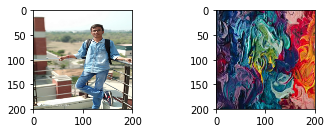

In [126]:
unloader = transforms.ToPILImage()

def imshow(tensor):
    image = tensor.clone()
    image = image.view(3, 200, 200)
    image = unloader(image)
    plt.imshow(image)
    
plt.figure(0)
plt.subplot(221)
imshow(content.data)

plt.subplot(222)
imshow(style.data)

ContentLoss


In [127]:
class ContentLoss(nn.Module): #it is taking three inputs ---content image ---image which we are updating 
    def __init__(self, target, weight): #---weight associated with contentloss(alpha)
        super(ContentLoss, self).__init__()
        self.target=target.detach()*weight
        self.weight = weight
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.loss = self.criterion.forward(input*self.weight, self.target)
        self.output = input
        return self.output
    
    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

In [128]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d=input.size()
        
        features = input.view(a*b, c*d)
        G = torch.mm(features, features.t())
        
        return G.div(a*b*c*d)

In [129]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach()*weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram.forward(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion.forward(self.G, self.target)
        return self.output
    
    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

In [130]:
cnn = models.vgg16(pretrained=True).features
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [131]:
#here we are only just initialising and making model not computing anything
content_layers= ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


content_losses = []
style_losses = []

model = nn.Sequential()
gram = GramMatrix()

content_weight = 1
style_weight = 10000

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = 'conv_' +str(i)
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model.forward(content).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module('content_loss'+str(i), content_loss)
            content_losses.append(content_loss)
           
        if name in style_layers:
            target_feature = model.forward(style).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module('style_loss'+str(i), style_loss)
            style_losses.append(style_loss)


    if isinstance(layer, nn.ReLU):
        name = 'relu_' + str(i)
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model.forward(content).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module('content_loss'+str(i), content_loss)
            content_losses.append(content_loss)
           
        if name in style_layers:
            target_feature = model.forward(style).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module('style_loss'+str(i), style_loss)
            style_losses.append(style_loss)
        i+=1
        
            
    if isinstance(layer, nn.MaxPool2d):
        name = 'pool_' + str(i)
        model.add_module(name, layer)

    

In [132]:
model

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss1): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_1): ReLU(inplace)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss2): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_2): ReLU(inplace)
  (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss3): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_3): ReLU(inplace)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss4): ContentLoss(
    (criterion): MSELoss()
  )
  (style_loss4): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_4): ReLU(inplace)
  (pool_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

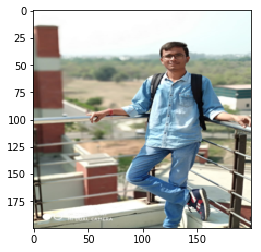

In [133]:
input = image_loader('/Users/adityakumar/Downloads/Aditya.jpeg').type(dtype)
imshow(input.data)
plt.show()

In [134]:
input = nn.Parameter(input.data)
optimizer = optim.LBFGS([input])#Limited-memory Broyden–Fletcher–Goldfarb–Shanno 

In [135]:
run = [0]
while run[0] <= 300:
    
    def closure():
        optimizer.zero_grad()
        model.forward(input)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.backward()
        for cl in content_losses:
            content_score += cl.backward()

        run[0]+=1
        if run[0] % 10 == 0:
            print("run " + str(run) + ":")
            print(style_score.data[0])
            print(content_score.data[0])

        return content_score+style_score

    optimizer.step(closure)

plt.subplot(224)
imshow(input.data)
plt.show()

run [10]:
tensor(6303.6621)
tensor(4.0041)


/Users/adityakumar/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/adityakumar/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


run [20]:
tensor(2028.4907)
tensor(4.8281)
run [30]:
tensor(1325.5952)
tensor(5.3897)
run [40]:
tensor(975.1843)
tensor(5.7335)
run [50]:
tensor(784.9692)
tensor(5.9965)
run [60]:
tensor(669.6402)
tensor(6.1192)
run [70]:
tensor(590.9892)
tensor(6.2714)
run [80]:
tensor(539.9682)
tensor(6.5826)
run [90]:
tensor(473.8230)
tensor(6.6189)
run [100]:
tensor(438.4885)
tensor(6.7197)
run [110]:
tensor(403.4768)
tensor(6.7948)


KeyboardInterrupt: 

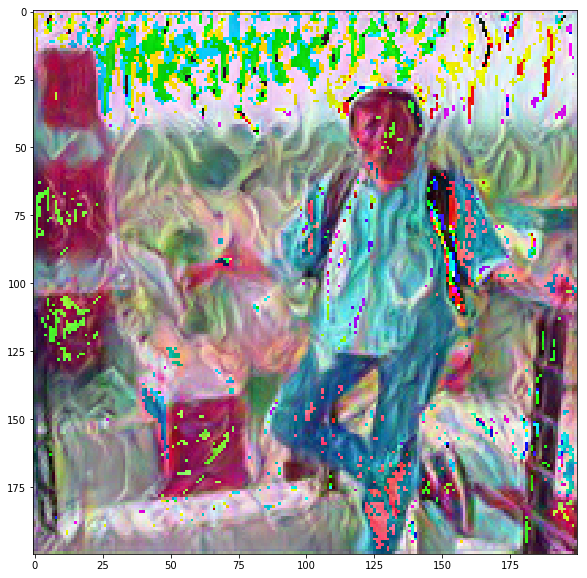

In [136]:
plt.figure(0, figsize=(10, 10))
imshow(input.data)

run [10]:
tensor(15.2080)
tensor(9.1114)


/Users/adityakumar/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/adityakumar/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


run [20]:
tensor(14.2891)
tensor(9.0851)
run [30]:
tensor(13.4464)
tensor(9.0399)
run [40]:
tensor(12.4233)
tensor(9.0107)
run [50]:
tensor(11.7216)
tensor(8.9692)
run [60]:
tensor(10.8814)
tensor(8.9353)
run [70]:
tensor(10.4619)
tensor(8.8898)
run [80]:
tensor(10.0475)
tensor(8.8648)
run [90]:
tensor(9.7309)
tensor(8.8287)
run [100]:
tensor(9.4658)
tensor(8.7974)
run [110]:
tensor(8.6000)
tensor(8.7740)
run [120]:
tensor(8.2321)
tensor(8.7464)


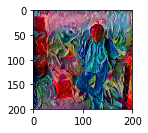

In [141]:
run = [0]
while run[0] <= 100:
    
    def closure():
        input.data.clamp_(0, 1)
        optimizer.zero_grad()
        model.forward(input)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.backward()
        for cl in content_losses:
            content_score += cl.backward()

        run[0]+=1
        if run[0] % 10 == 0:
            print("run " + str(run) + ":")
            print(style_score.data[0])
            print(content_score.data[0])

        return content_score+style_score

    optimizer.step(closure)
input.data.clamp_(0, 1)
plt.subplot(224)
imshow(input.data)
plt.show()

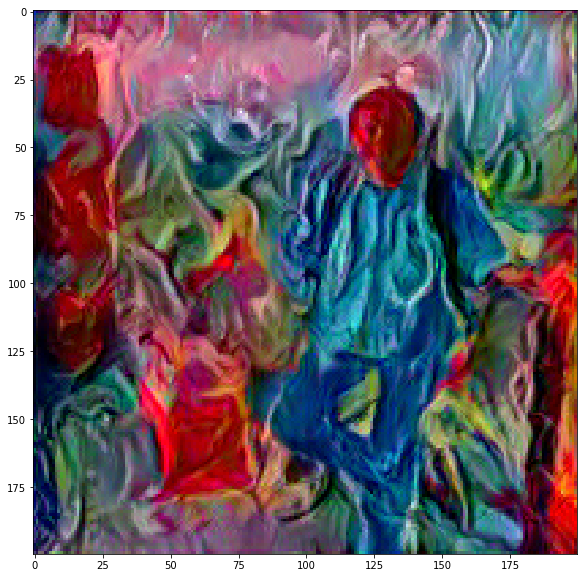

In [142]:
plt.figure(0, figsize=(10, 10))
imshow(input.data)